In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import collections
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.layers import Embedding, Input, Conv1D, MaxPooling1D, Dropout, Concatenate, Flatten, Dense
from keras.initializers import Constant
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
# leer los datos
datos = pd.read_json("../Prubeas WJ/Datos/News/News_Category_Dataset_v2.json", lines=True)
datos.head()

,authors,category,date,headline,link,short_description
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."


In [3]:
# dejar los encabezados y descripción en una sola variable
# tokenizar las palabras de esta variable nueva

datos['text'] = datos['headline'] + " " + datos['short_description']

tokenizer = Tokenizer()
tokenizer.fit_on_texts(datos['text'])

token = tokenizer.texts_to_sequences(datos['text'])
datos['tokens'] = token

In [4]:
categories = datos.groupby('category').size().index.tolist()
category_int = {}
int_category = {}

for i, k in enumerate(categories):
    category_int.update({k:i})
    int_category.update({i:k})


In [5]:
# asignar a cada categoria un id

encoder = preprocessing.LabelEncoder()
datos['cat_id'] = encoder.fit_transform(datos.category.values)

In [6]:
# embeding con datos pre-entrenados de GloVe 
# variables para los tensores y el modelo

word_index = tokenizer.word_index
dim_embedddings = 100
embeddings_index = {}
maxlen = 50
V = len(tokenizer.word_index) + 1

f = open('../Prubeas WJ/Datos/News/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s unique tokens.' % len(word_index))
print('Total %s word vectors.' % len(embeddings_index))

Found 116617 unique tokens.
Total 400000 word vectors.


In [7]:
w_inputs = Input(shape=(maxlen, ), dtype='int32')
w = Embedding(V, dim_embedddings)(w_inputs)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
X = np.array(list(sequence.pad_sequences(datos['tokens'], maxlen=maxlen)))
Y = np_utils.to_categorical(list(datos.cat_id))

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2)

In [9]:
stacks = []
for kernel_size in [2, 3, 4]:
    conv = Conv1D(64, kernel_size, padding='same', activation='relu', strides=1)(w)
    pool = MaxPooling1D(pool_size=3)(conv)
    drop = Dropout(0.5)(pool)
    stacks.append(drop)

merged = Concatenate()(stacks)
flatten = Flatten()(merged)
drop = Dropout(0.5)(flatten)
outp = Dense(len(int_category), activation='softmax')(drop)

TextCNN = Model(inputs=w_inputs, outputs=outp)
TextCNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

TextCNN.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 100)      11661800    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 50, 64)       12864       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 50, 64)       19264       embedding_1[0][0]           

In [10]:
result_model = TextCNN.fit(x_train, 
                              y_train, 
                              batch_size=128, 
                              epochs=10, 
                              validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 160682 samples, validate on 40171 samples
Epoch 1/10
160682/160682 [==============================] - 301s 2ms/step - loss: 2.3276 - acc: 0.3987 - val_loss: 1.7010 - val_acc: 0.5559
Epoch 2/10
160682/160682 [==============================] - 302s 2ms/step - loss: 1.5550 - acc: 0.5839 - val_loss: 1.4969 - val_acc: 0.6050
Epoch 3/10
160682/160682 [==============================] - 308s 2ms/step - loss: 1.2262 - acc: 0.6589 - val_loss: 1.4864 - val_acc: 0.6097
Epoch 4/10
160682/160682 [==============================] - 308s 2ms/step - loss: 1.0057 - acc: 0.7132 - val_loss: 1.5463 - val_acc: 0.6028
Epoch 5/10
160682/160682 [==============================] - 310s 2ms/step - loss: 0.8396 - acc: 0.7579 - val_loss: 1.6492 - val_acc: 0.5973
Epoch 6/10
160682/160682 [==============================] - 312s 2ms/step - loss: 0.7177 - acc: 0.7891 - val_loss: 1.7659 - val_acc: 0.5944
Epoch 7/10
160682/160682 [==============================] - 3

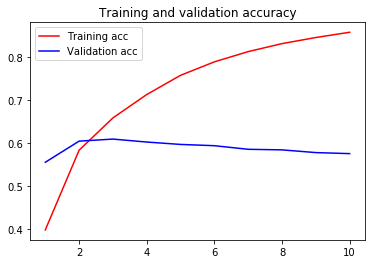

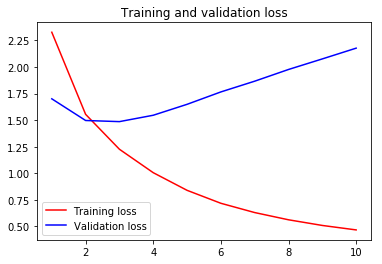

In [11]:
acc = result_model.history['acc']
val_acc = result_model.history['val_acc']
loss = result_model.history['loss']
val_loss = result_model.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()

plt.show()

# Descriptivo

In [15]:
datos.cat_id.describe()

count    200853.000000
mean         22.125420
std          10.882725
min           0.000000
25%          13.000000
50%          24.000000
75%          30.000000
max          40.000000
Name: cat_id, dtype: float64

In [17]:
datos.category.describe()

count       200853
unique          41
top       POLITICS
freq         32739
Name: category, dtype: object

In [18]:
datos.short_description.describe()

count     200853
unique    178353
top             
freq       19712
Name: short_description, dtype: object

In [21]:
datos.authors.describe()

count     200853
unique     27993
top             
freq       36620
Name: authors, dtype: object

# ¿Qué información útil se puede extraer de los datos?

Con los datos que se tienen es posible realizar generar un encabezado dependiendo de la descripción.